# Hand drawn circuit diagram analyzer 
## Digital Image Processing 
#### Sara Jameel and Muhammad Shahrom Ali

###### Importing and Housekeeping 

In [31]:
import numpy as np 

import cvxopt

import cv2

from sklearn import svm
from skimage import color

from skimage.feature import hog
from skimage.morphology import skeletonize
from sklearn.metrics import classification_report,accuracy_score
from skimage.util import invert

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [32]:
# Supporting information defined 
dataset_info = {
    # FORMAT::component_type: (no_of_imgs, label_value, format)
    'voltagesource' : (100, 0, '.png'),
    'resistor' : (100, 1, '.jpeg')
}

#Label_value (int) : component_type (string)
labels = {dataset_info[i][1] : i for i in dataset_info}

###### Classes

In [33]:
class VoltageSource():
    def __init__(self, v, p1, p2):
        self.voltage = v
        self.v_out = p2 # The connection where the current leaves the power source 
        self.v_in = p1 # The connection where the curret reaches the power source back 

In [34]:
class Resistor():
    def __init__(self , r, p1, p2):
        self.resistance = r
        self.p1 = p1
        self.p2 = p2

###### Load Data 

In [35]:
def preprocess_data(img):
    
    #Resize the image for less pixels 
    width = 100
    height = 100
    dim = (width, height) 
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 

    #convert image to grayscale 
    if img.shape[2] == 4:
        img = color.rgb2gray(color.rgba2rgb(img))
    elif img.shape[2] == 3:
        img = color.rgb2gray(img)
    return img

In [36]:
def load_dataset():
    handy_dataset = list()
    
    for component_type in dataset_info:
    
        img_count = dataset_info[component_type][0]
        component_label = dataset_info[component_type][1]
        file_ext = dataset_info[component_type][2]
        
        #LOAD IMAGES OF SELECTED COMPONENT TYPE
        for i in range(1,  img_count + 1):

            img_path = './traindata/' + component_type + "/" + str(i) + file_ext
            
            img = preprocess_data( mpimg.imread( img_path ) ) 

            handy_dataset.append((img, component_label))

    #Loaded Dataset
    handy_dataset = np.array(handy_dataset, dtype=object)
    
    return handy_dataset

##### Image Processing

In [37]:
def smoothing_img(img, show = False):
    # Smoothing image using Gaussian filtering 
    kernel = np.ones((5,5),np.float32)/25
    retval = cv2.filter2D(img,-1,kernel)
    
    if show:
        plt.subplot(121), plt.imshow(img), plt.title('Original Image ')
        plt.subplot(122), plt.imshow(retval), plt.title('After Gaussian Filtering')
        
    return retval

In [38]:
def make_binary(img, show = False):
    ret,thresh = cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)
    
#     thresh = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    if show:
        
        plt.subplot(211), plt.imshow(img), plt.title('Original Image')
        plt.subplot(212), plt.imshow(thresh), plt.title('Binary Inverted')
        
    return thresh

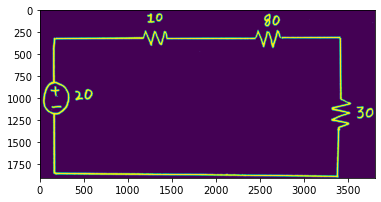

In [39]:
img = cv2.imread('./Images/Circuit_1.png', 0)
img = smoothing_img(img)
img = make_binary(img)
# 


# cv2.rectangle(img, (270, 1492), (310, 2500), (255, 0, 0), 2 )

plt.imshow(img)
plt.show()


In [40]:
def check_neighbors(img, i, j):
    #Apply on skeletonized image 
    # i could be 0
    # j could be 0
    nbhd = []
    
    nbrs_eight = [
        (i-1, j-1),
        (i, j-1),
        (i+1, j-1),
        (i-1, j),
        (i+1, j),
        (i-1, j+1),
        (i, j+1),
        (i+1, j+1),
    ]
    
    for n in nbrs_eight:
        if 0 <= n[0] < img.shape[0] and 0 <= n[1] < img.shape[1]:

            if img[n[0], n[1]] == True:
                nbhd.append(n)
                
    
    return nbhd

In [41]:
def get_neighbors(img, i, j):
    nbhd = []
    
    nbrs_eight = [
        (i-1, j-1),
        (i, j-1),
        (i+1, j-1),
        (i-1, j),
        (i, j),
        (i+1, j),
        (i-1, j+1),
        (i, j+1),
        (i+1, j+1),
    ]
    
    for n in nbrs_eight:
        if 0 <= n[0] < img.shape[0] and 0 <= n[1] < img.shape[1]:
            nbhd.append(n)
    
    return nbhd

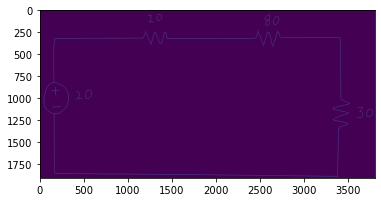

In [42]:
sk_img = skeletonize(img / 255)
img = smoothing_img(img)
plt.imshow(sk_img)
plt.show()

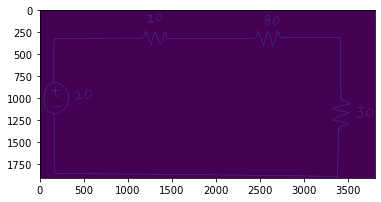

In [43]:
endpoints = []

for i in range(sk_img.shape[0]):
    for j in range(sk_img.shape[1]):
        if sk_img[i,j] == True:
            nbhd_ij = check_neighbors(sk_img, i, j)
            if len(nbhd_ij) == 1:
                endpoints.append((i, j))

for n in endpoints:
    for m in get_neighbors(sk_img, n[0], n[1]):
        sk_img[m[0], m[1]] = True
        
plt.imshow(sk_img)
plt.show()

###### Feature Extraction

In [44]:
def feature_extraction(img):
    ppc = 16 #PIXELS PER CEL 
    return hog(img, 
               orientations=8,
               pixels_per_cell=(ppc,ppc),
               cells_per_block=(4, 4),
               block_norm= 'L2',
               visualize=True)

In [45]:
def gen_feature_set(dataset):
    #Feature Extraction using Histogram of Gradient
    
    hog_images = []
    hog_features = []

    for image in dataset:

        feat_desc, hog_image = feature_extraction(image[0])

        hog_images.append(hog_image)
        hog_features.append(feat_desc)
    
    hog_features = np.array(hog_features)
    labels = np.array( [img[1] for img in dataset] ).reshape(len(dataset), 1) #make collumn vector

    # each row corresponds to hog_features of some img i
    # and at the end is the label of that image 
    data_frame = np.hstack((hog_features, labels))
    
    return data_frame

###### Splitting Data

In [46]:
def split_data(data_frame):
    
    percentage = 80
    partition = int(data_frame.shape[0]*percentage/100)
    
    x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
    
    y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()
    
    return (x_train, y_train, x_test, y_test)

###### Classifier

In [47]:
def classifier(x_train, y_train):    
    # Lib implementation
    model_handy = svm.SVC()
    model_handy.fit(x_train,y_train)
    
    return model_handy

##### Predictions and Model Evaluations

In [48]:
def model_eval(y_test, y_pred):
    print("Accuracy: " + str(accuracy_score(y_test, y_pred) * 100) + "%")
    print('\n')
    print(classification_report(y_test, y_pred))

###### Run

In [49]:
# Load Dataset 
handy_dataset = load_dataset()
print("Dataset Loaded...")

# Shuffle Dataset
np.random.shuffle(handy_dataset)

# Extract Features and Create Feature Set
handy_data_frame = gen_feature_set(handy_dataset)
print("Featureset generated...")

# Split Feature Set 
x_train, y_train, x_test, y_test = split_data(handy_data_frame)

Dataset Loaded...
Featureset generated...


In [50]:
# Fit Model
handy_classifier = classifier(x_train, y_train)
print("Handy Model Loaded...")

Handy Model Loaded...


In [51]:
#Test Model
y_pred = handy_classifier.predict(x_test)

In [52]:
model_eval(y_test, y_pred)

Accuracy: 100.0%


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        22
         1.0       1.00      1.00      1.00        18

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



This symbol is a voltagesource


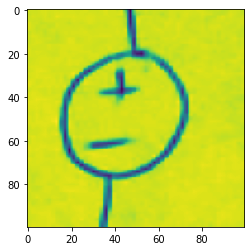

In [53]:
img = preprocess_data(mpimg.imread('./Images/test10.PNG'))
plt.imshow(img)
plt.show

feat_vec, feat_img = feature_extraction(img) 

pred = labels[np.array(handy_classifier.predict(np.array([feat_vec,])))[0]]

print('This symbol is a ' + pred)